<a href="https://colab.research.google.com/github/regraded0101/pytorch/blob/main/sonar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
sonar_df = pd.read_csv('sonar_csv.csv')
X_np = sonar_df.drop('Class', axis=1).values
X_np = X_np.astype(np.float32)

# Mine = 0, Rock = 1, no NA values
target_np = np.where(sonar_df['Class'] == 'Mine', 0, 1)
target_np = target_np.astype(np.float32)

In [3]:
from sklearn.model_selection import train_test_split

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_np, target_np,
    random_state=42, test_size=0.3
)

In [4]:
import torch

In [5]:
X_train = torch.tensor(X_train_np)
y_train = torch.tensor(y_train_np)
X_test = torch.tensor(X_test_np)
y_test = torch.tensor(y_test_np)


In [6]:
from torch import nn

In [7]:
class Deep(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(60,60)
    self.act1 = nn.ReLU()
    self.layer2 = nn.Linear(60,180)
    self.act2 = nn.ReLU()
    self.layer3 = nn.Linear(180,60)
    self.act3 = nn.ReLU()
    self.output = nn.Linear(60,1)
    self.sig = nn.Sigmoid()

  def forward(self, x):
    x = self.act1(self.layer1(x))
    x = self.act2(self.layer2(x))
    x = self.act3(self.layer3(x))
    x = self.sig(self.output(x))
    return x



In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_deep = Deep()
model_deep = model_deep.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device).unsqueeze(-1)
X_test = X_test.to(device)
y_test = y_test.to(device).unsqueeze(-1)
print(f"Running on :{device}")


Running on :cuda


In [9]:
loss_func = nn.BCELoss()
optim = torch.optim.Adam(
    params=model_deep.parameters(),
    lr=0.0001
)

In [10]:
n_epochs = 250
batch_size = 10

eval_metrics = {}

batch_id = torch.arange(start=0, end=len(X_train), step=batch_size)

for epoch in range(n_epochs):
  for batch in batch_id:
    model_deep.train()

    X_batch = X_train[batch:batch + batch_size]
    y_batch = y_train[batch:batch + batch_size]

    y_pred = model_deep(X_batch)
    loss = loss_func(y_pred, y_batch)

    optim.zero_grad()
    loss.backward()

    # update weights
    optim.step()

  # calculate the test accuracy
  model_deep.eval()
  y_val = model_deep(X_test)
  acc = (y_val.round() == y_test).float().mean()


  # calculate the training accuracy
  y_train_val = model_deep(X_train)
  acc_train = (y_train_val.round() == y_train).float().mean()

  eval_metrics[epoch]=[acc.item(), acc_train.item(), loss.item()]

  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Loss: {round(loss.item(),6)}")
    print(f"Test Accuracy: {round(acc.item(),6)}")
    print(f"Train Accuracy: {round(acc_train.item(),6)}\n")




Epoch: 0, Loss: 0.692456
Test Accuracy: 0.555556
Train Accuracy: 0.524138

Epoch: 10, Loss: 0.684196
Test Accuracy: 0.650794
Train Accuracy: 0.586207

Epoch: 20, Loss: 0.66696
Test Accuracy: 0.746032
Train Accuracy: 0.751724

Epoch: 30, Loss: 0.645432
Test Accuracy: 0.84127
Train Accuracy: 0.813793

Epoch: 40, Loss: 0.594836
Test Accuracy: 0.825397
Train Accuracy: 0.841379

Epoch: 50, Loss: 0.53504
Test Accuracy: 0.825397
Train Accuracy: 0.855172

Epoch: 60, Loss: 0.464952
Test Accuracy: 0.857143
Train Accuracy: 0.875862

Epoch: 70, Loss: 0.394705
Test Accuracy: 0.873016
Train Accuracy: 0.882759

Epoch: 80, Loss: 0.336073
Test Accuracy: 0.873016
Train Accuracy: 0.889655

Epoch: 90, Loss: 0.282347
Test Accuracy: 0.888889
Train Accuracy: 0.896552

Epoch: 100, Loss: 0.234181
Test Accuracy: 0.920635
Train Accuracy: 0.931035

Epoch: 110, Loss: 0.194192
Test Accuracy: 0.920635
Train Accuracy: 0.937931

Epoch: 120, Loss: 0.157549
Test Accuracy: 0.920635
Train Accuracy: 0.965517

Epoch: 130, L

In [11]:
eval_metrics_df = pd.DataFrame(eval_metrics).T
eval_metrics_df.columns = ['test_acc', 'train_acc', 'loss']
eval_metrics_df

,test_acc,train_acc,loss
0,0.555556,0.524138,0.692456
1,0.555556,0.524138,0.691698
2,0.555556,0.524138,0.690896
3,0.555556,0.524138,0.690113
4,0.555556,0.524138,0.689336
...,...,...,...
245,0.920635,1.000000,0.010629
246,0.920635,1.000000,0.010467
247,0.920635,1.000000,0.010294
248,0.920635,1.000000,0.010020


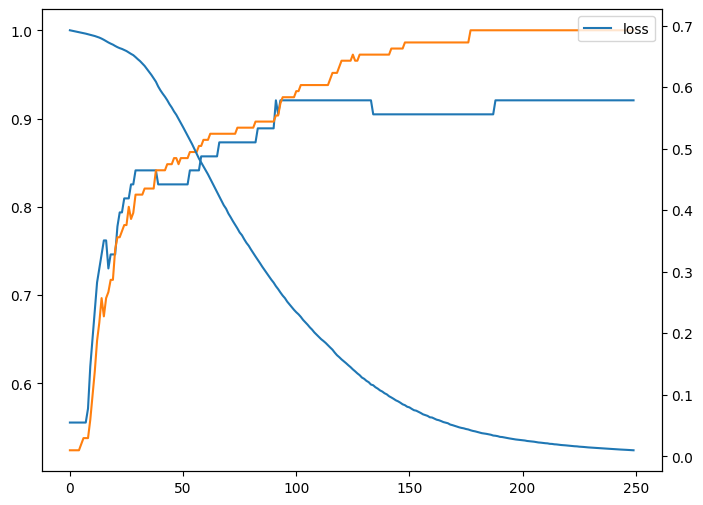

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))

plt.plot(eval_metrics_df.index, eval_metrics_df['test_acc'], label='Test Accuracy')
plt.plot(eval_metrics_df.index, eval_metrics_df['train_acc'], label='Training Accuracy')

ax2 = plt.twinx()
ax2.plot(eval_metrics_df.index, eval_metrics_df['loss'], label='loss')

plt.xlabel('epoch')
plt.legend()